In [3]:
import pandas as pd
import numpy as np

files = {
    "Panama City": "data/PanamaCityWeather.csv",
    "Gainesville": "data/GainsvilleWeather.csv",
    "Miami": "data/MiamiWeather.csv",
    "Orlando": "data/OrlandoWeather.csv",
    "Tampa": "data/TampaWeather.csv"
}
dfs = []
for city, file_path in files.items():
    df = pd.read_csv(file_path)
    df['City'] = city
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
#clean up white spaces
combined_df.columns = combined_df.columns.str.strip()
# change -99 to nan to rmeove later
combined_df.replace([-99.9, -99.99], np.nan, inplace=True)

combined_df['Date'] = pd.to_datetime(
    combined_df[['YEAR', 'MONTH', 'DAY']].rename(columns={
        'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'
    }),
    errors='coerce'
)
# remove any of the -99
combined_df.dropna(subset=['Date'], inplace=True)
#remove any of the -99
combined_df_clean = combined_df.dropna(subset=["PRECIPITATION", "MAX TEMP", "MIN TEMP", "MEAN TEMP"])

combined_df_clean.reset_index(drop=True, inplace=True)

print(combined_df_clean.head())


   COOPID  YEAR  MONTH  DAY  PRECIPITATION  MAX TEMP  MIN TEMP  MEAN TEMP  \
0   83326  1960      5   17            0.0      90.0      64.0       77.0   
1   83326  1960      5   18            0.0      92.0      62.0       77.0   
2   83326  1960      5   19            0.0      94.0      59.0       76.5   
3   83326  1960      5   20            0.0      89.0      68.0       78.5   
4   83326  1960      5   21            0.0      91.0      65.0       78.0   

          City       Date  
0  Panama City 1960-05-17  
1  Panama City 1960-05-18  
2  Panama City 1960-05-19  
3  Panama City 1960-05-20  
4  Panama City 1960-05-21  


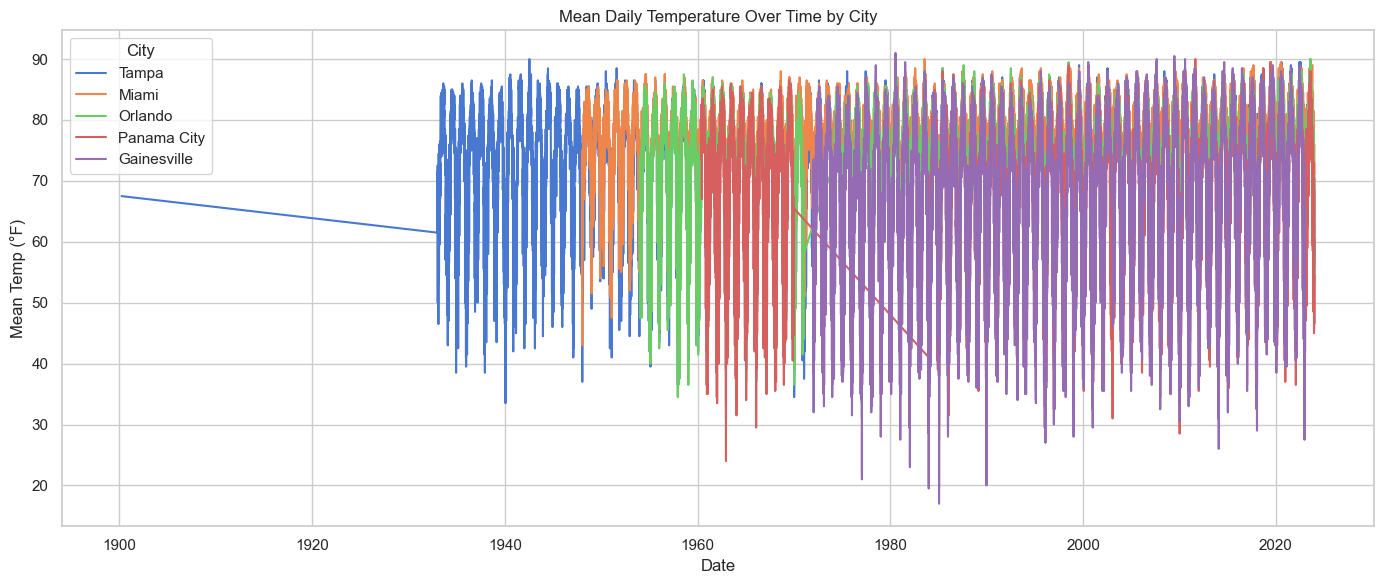

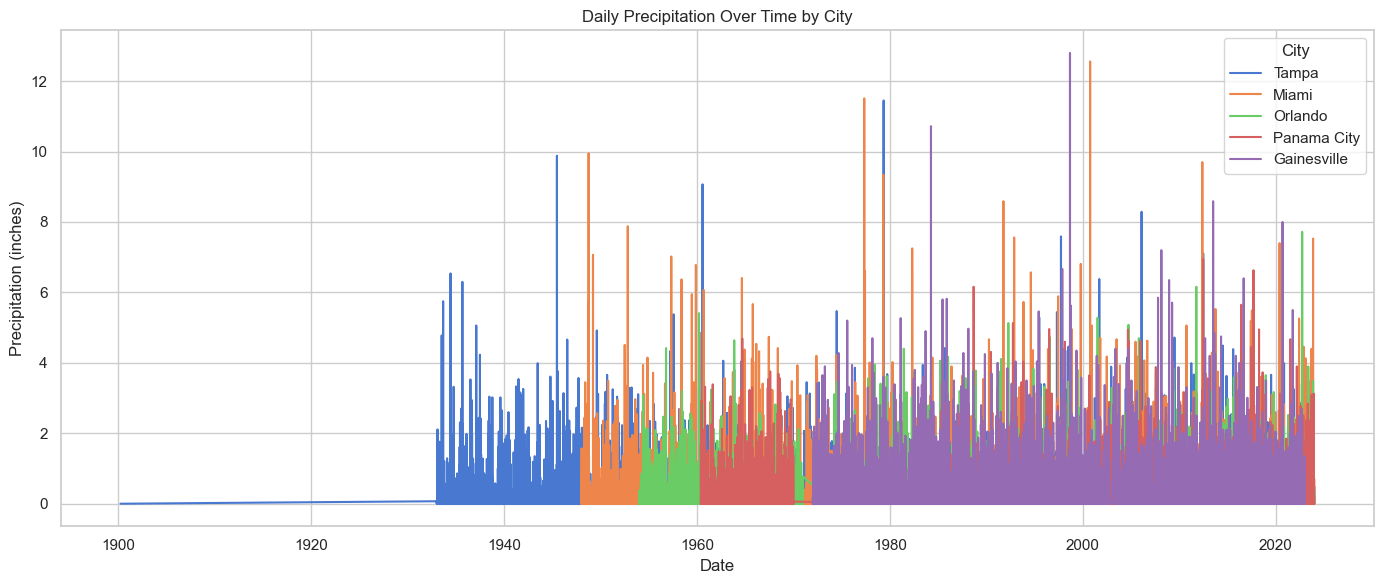

/var/folders/xf/lm9021bs2f1393mykjtyplf40000gn/T/ipykernel_70900/3505602918.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_clean.loc[:, 'Month'] = combined_df_clean['Date'].dt.month


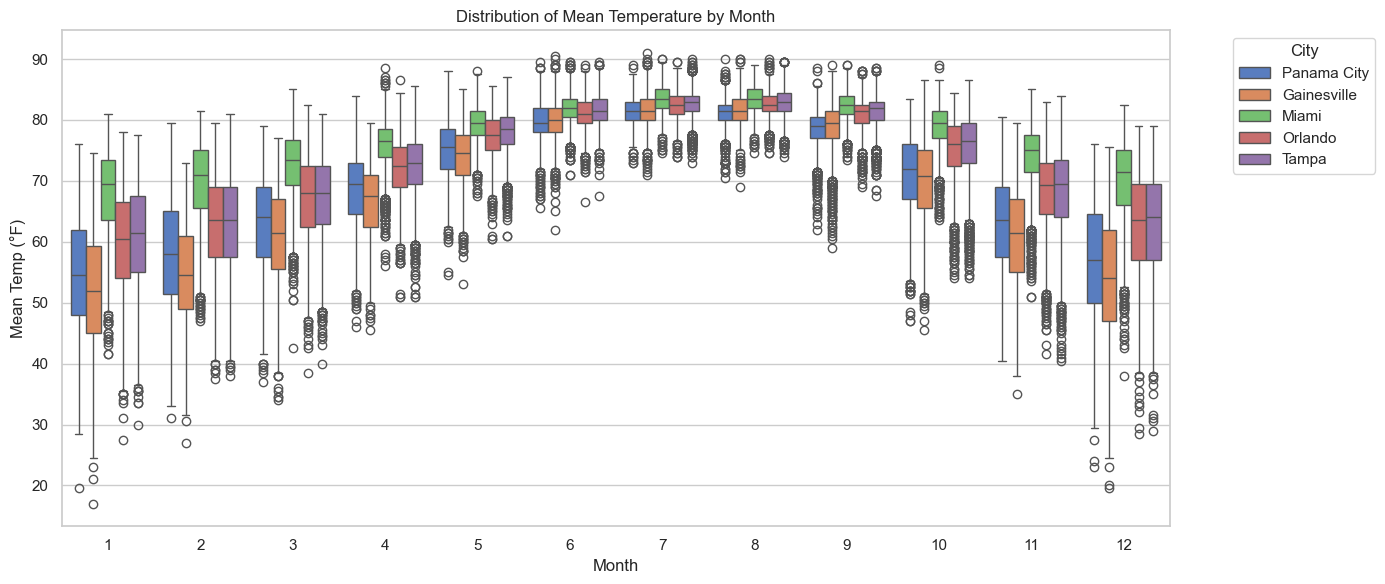

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)

city_daily_avg = combined_df_clean.groupby(['Date', 'City']).agg({
    'PRECIPITATION': 'mean',
    'MEAN TEMP': 'mean',
    'MAX TEMP': 'mean',
    'MIN TEMP': 'mean'
}).reset_index()

#mean temp over time but again doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='MEAN TEMP', hue='City')
plt.title("Mean Daily Temperature Over Time by City")
plt.xlabel("Date")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#precipitation over time but it doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='PRECIPITATION', hue='City')
plt.title("Daily Precipitation Over Time by City")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#box plot of temp by month idk if this helps?
combined_df_clean.loc[:, 'Month'] = combined_df_clean['Date'].dt.month

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df_clean, x='Month', y='MEAN TEMP', hue='City')
plt.title("Distribution of Mean Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



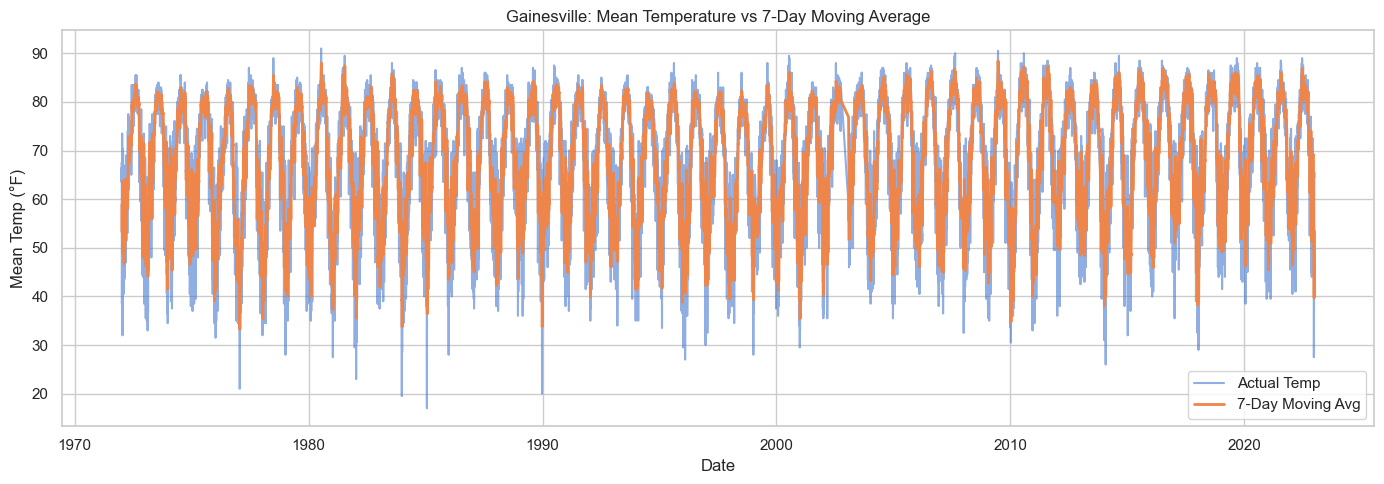

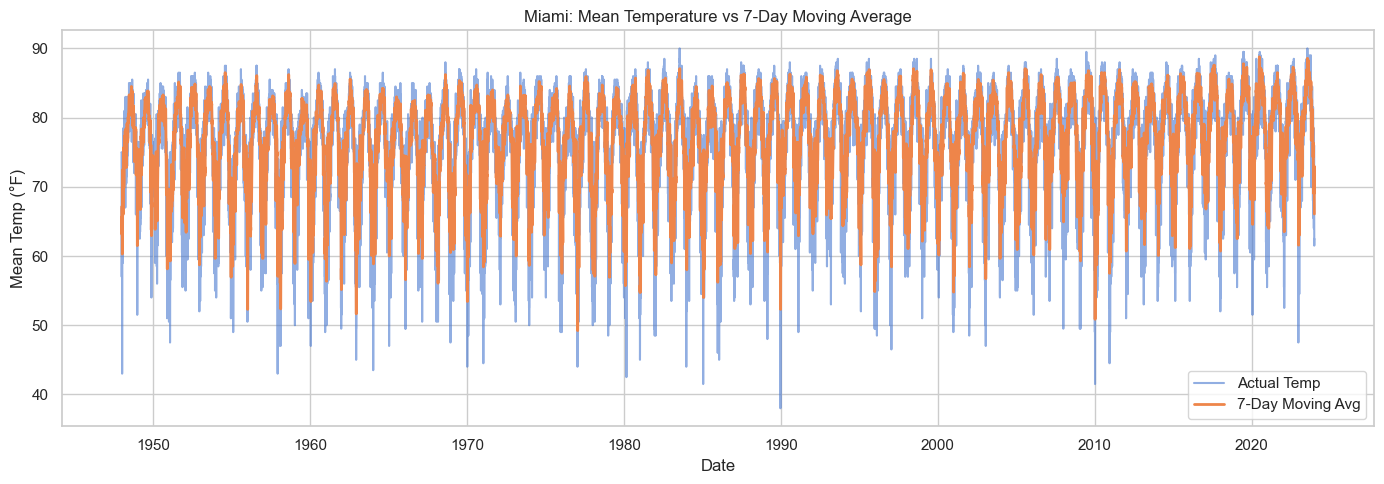

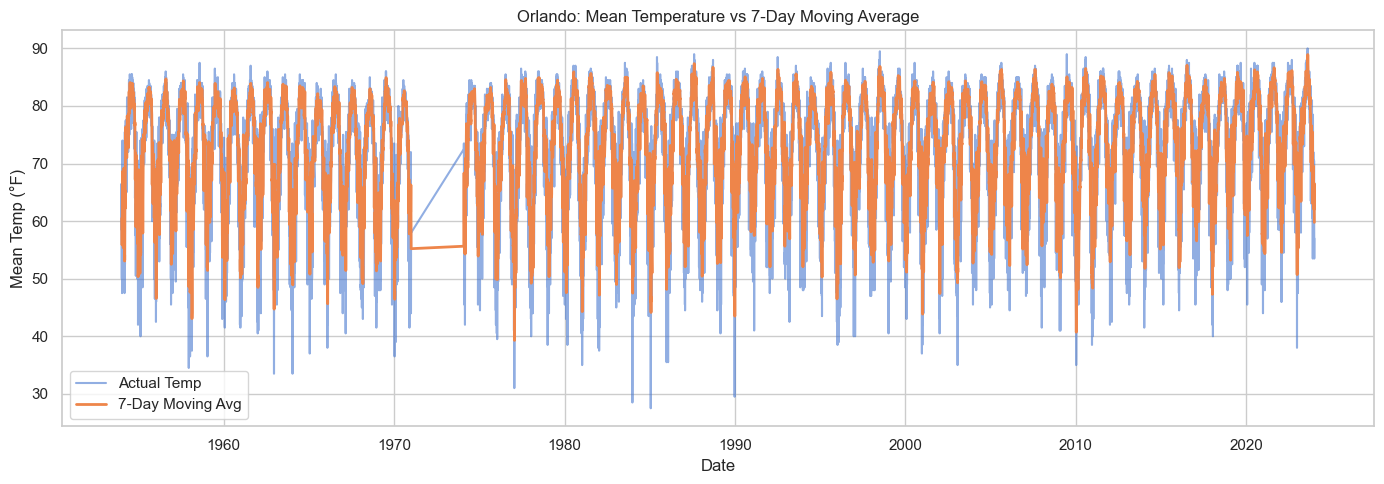

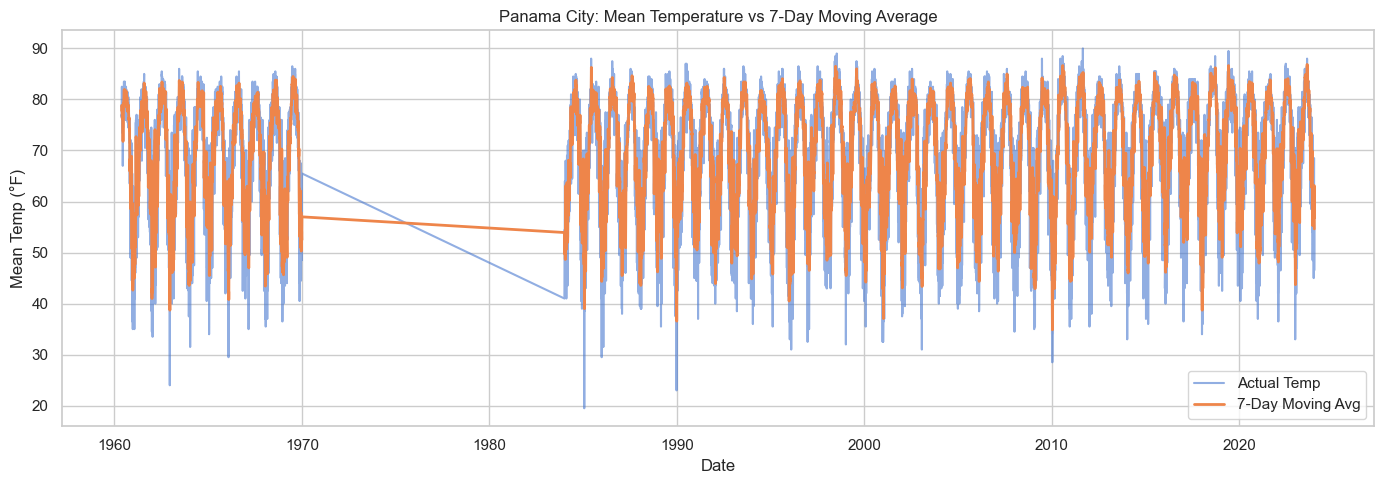

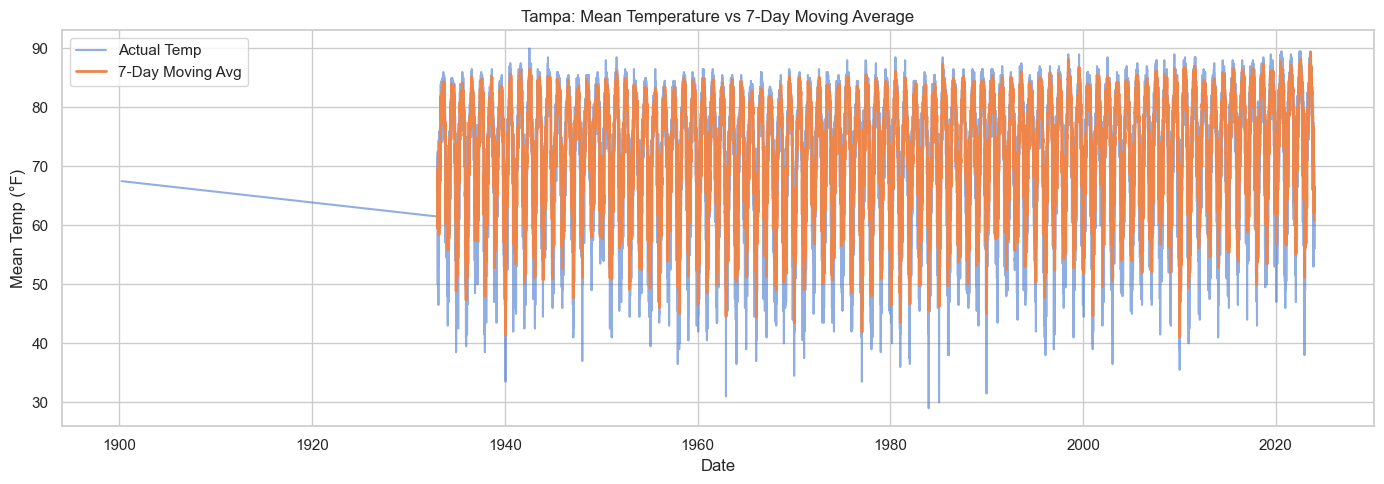

In [5]:
#7 day moving average for each of the cities
city_ma_df = combined_df_clean.copy()
city_ma_df.sort_values(by=["City", "Date"], inplace=True)

city_ma_df["TEMP_7D_MA"] = city_ma_df.groupby("City")["MEAN TEMP"].transform(lambda x: x.rolling(window=7).mean())
city_ma_df["PRECIP_7D_MA"] = city_ma_df.groupby("City")["PRECIPITATION"].transform(lambda x: x.rolling(window=7).mean())

cities = city_ma_df["City"].unique()

for city in cities:
    city_data = city_ma_df[city_ma_df["City"] == city]
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=city_data, x="Date", y="MEAN TEMP", label="Actual Temp", alpha=0.6)
    sns.lineplot(data=city_data, x="Date", y="TEMP_7D_MA", label="7-Day Moving Avg", linewidth=2)
    plt.title(f"{city}: Mean Temperature vs 7-Day Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Mean Temp (°F)")
    plt.legend()
    plt.tight_layout()
    plt.show()


Gainesville - MSE: 0.2631, R² Score: 0.0074, Training Time: 0.0090s, Prediction Time: 0.0017s
Miami - MSE: 0.2921, R² Score: 0.0026, Training Time: 0.0037s, Prediction Time: 0.0016s
Orlando - MSE: 0.1524, R² Score: 0.0051, Training Time: 0.0040s, Prediction Time: 0.0017s
Panama City - MSE: 0.1676, R² Score: -0.0022, Training Time: 0.0041s, Prediction Time: 0.0013s
Tampa - MSE: 0.1629, R² Score: 0.0017, Training Time: 0.0053s, Prediction Time: 0.0018s


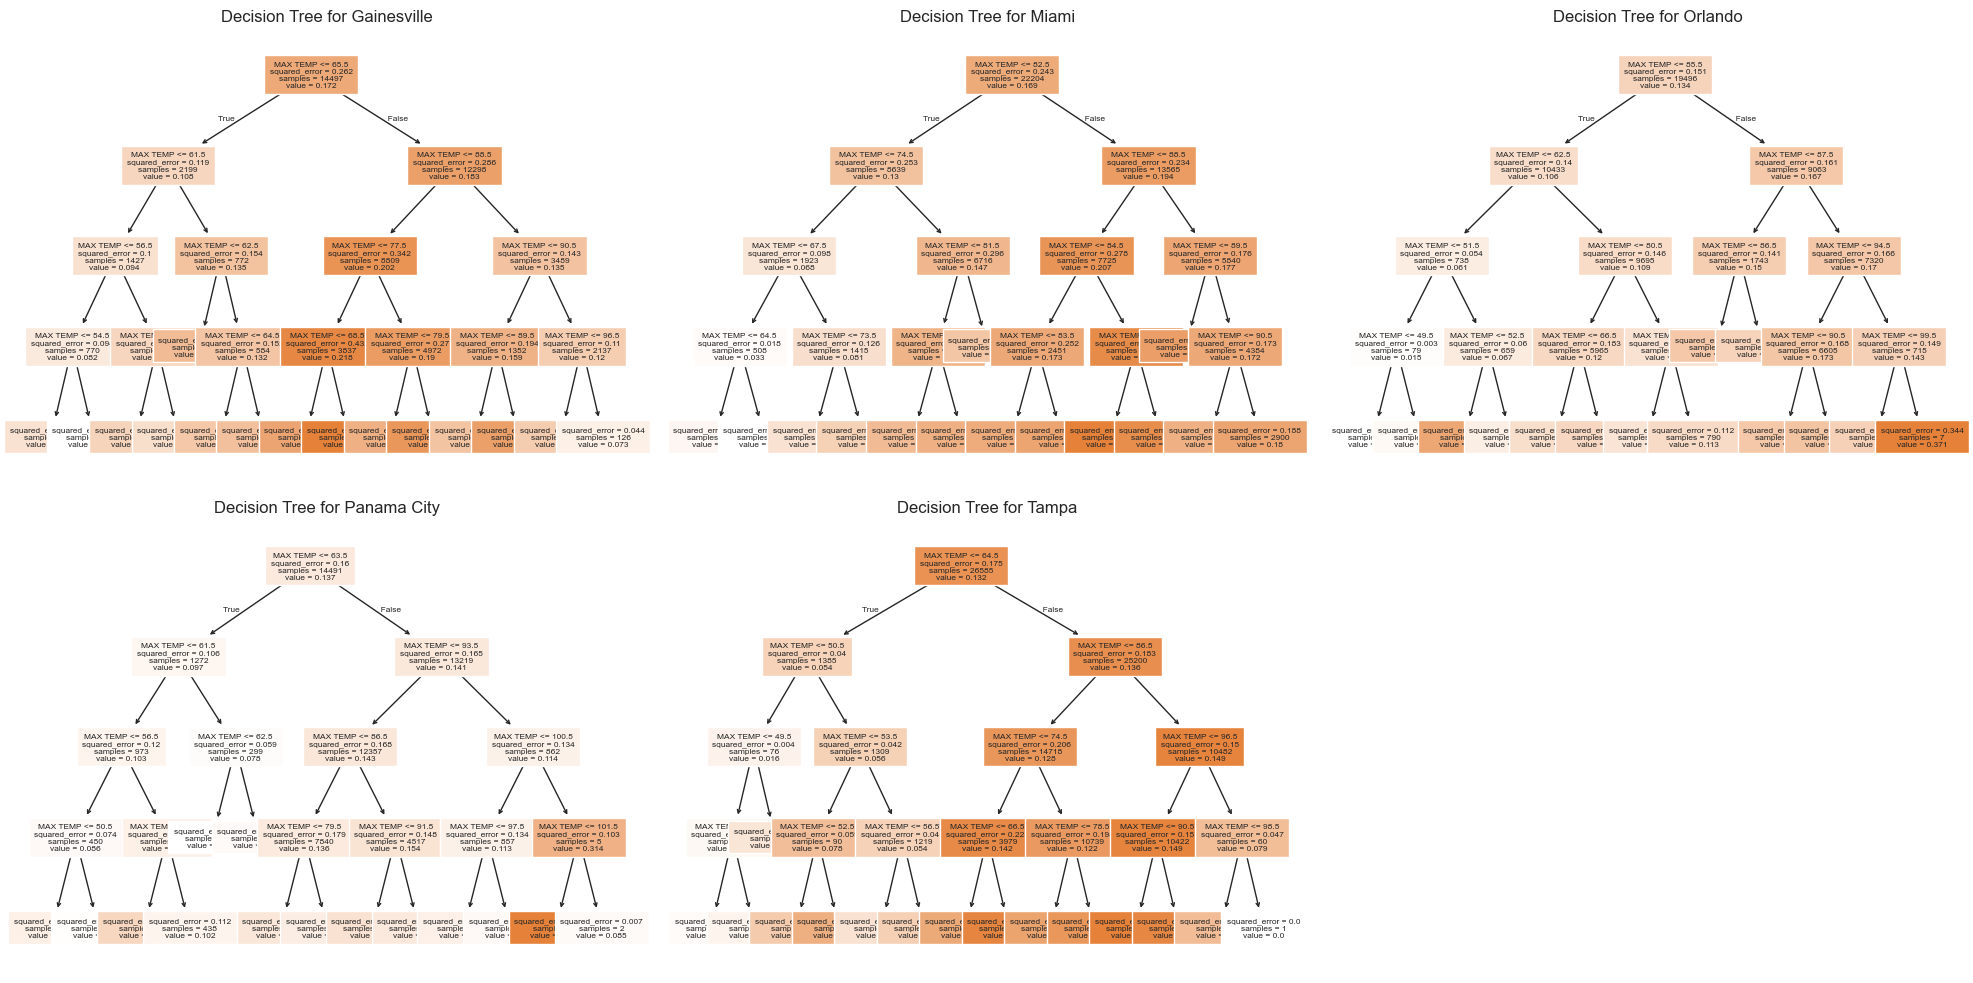

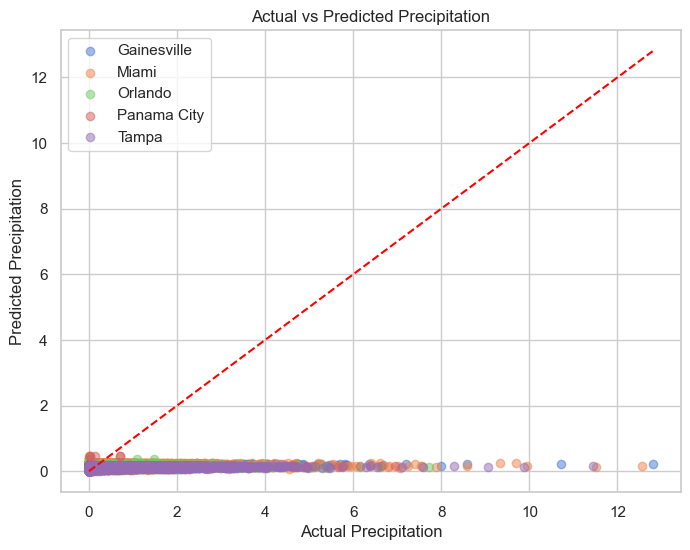

In [6]:
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

city_models = {}

plt.figure(figsize=(20, 10))

for i, city in enumerate(cities, 1):
    city_data = combined_df_clean[combined_df_clean['City'] == city]

    # Selecting relevant features and target
    X = city_data[['MAX TEMP']]
    y = city_data['PRECIPITATION']

    # Split into training and testing sets (80%, 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    
    # Train Decision Tree Regressor
    model = DecisionTreeRegressor(max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    city_models[city] = model

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{city} - MSE: {mse:.4f}, R² Score: {r2:.4f}, Training Time: {training_time:.4f}s, Prediction Time: {prediction_time:.4f}s")

    # Plot decision tree for each city
    plt.subplot(2, len(cities)//2 + 1, i)
    plot_tree(model, feature_names=['MAX TEMP'], filled=True, fontsize=6)
    plt.title(f'Decision Tree for {city}')

plt.tight_layout()  
plt.show()

# Scatter plot to visualize actual vs predicted precipitation
plt.figure(figsize=(8, 6))
for city, model in city_models.items():
    city_data = combined_df_clean[combined_df_clean['City'] == city]
    X_city = city_data[['MAX TEMP']]
    y_city_actual = city_data['PRECIPITATION']
    y_city_pred = model.predict(X_city)

    plt.scatter(y_city_actual, y_city_pred, label=city, alpha=0.5)

plt.plot([min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         [min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         color='red', linestyle='--')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend()
plt.title('Actual vs Predicted Precipitation')
plt.show()
